# SRISHTI'23 - Tutorial 11
## Convolutional Neural Networks

### Lab coordinator: Kushagra Agarwal

## 1. Understanding Convolutions

<img src="https://miro.medium.com/max/464/0*e-SMFTzO8r7skkpc" width=650px/>

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Importing some pytorch packages
import torch
from torch.nn import Conv2d

Central to CNNs, a convolution operation is a linear element-wise multiplication operation between a small filter/kernel and same-sized patch from the image. We move this filter over the image like a sliding window from top left to bottom right. For each point on the image, a value is calculated based on the filter using a convolution operation. These filters can do simplest task like checking if there is a vertical line in the image or complicated task like detecting a human eye in the image.

Let's look at the convolution formula:

Convolution between image
$f(x, y)$ and kernel $k(x, y)$ is
$$f(x,y) * k(x,y) = \sum \limits _{i=0} ^{W-1} \sum \limits _{j=0} ^{H-1} f(i, j) k(x − i, y − j)$$

where $W$ and $H$ are the the width and height of the image.

The code demonstrates the convolution operation of a 2D matrix (image) with various filters

<img src="https://www.researchgate.net/profile/Chaim-Baskin/publication/318849314/figure/fig1/AS:614287726870532@1523469015098/Image-convolution-with-an-input-image-of-size-7-7-and-a-filter-kernel-of-size-3-3.png" alt="Convolution" width=650px height=280px/>

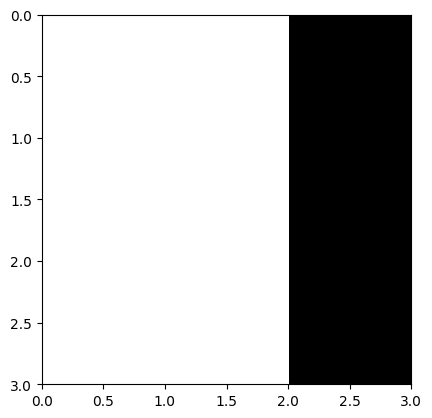

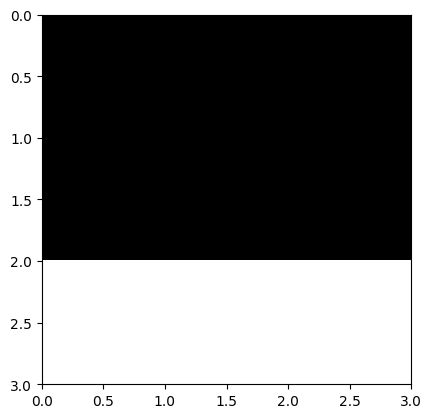

In [3]:
# 2D 3x3 binary image with vertical edge
image1 = np.array([[1,1,0], [1,1,0], [1,1,0]])

# 2D 3x3 binary image with horizontal edge
image2 = np.array([[0,0,0], [0,0,0], [1,1,1]])

# On plotting the images
plt.imshow(image1, cmap='gray', extent=[0, 3, 3, 0])
plt.show()
plt.imshow(image2, cmap='gray', extent=[0, 3, 3, 0])
plt.show()

In [4]:
# Vertical Line filter
filter = np.array([[1,0,-1],
                   [1,0,-1],
                   [1,0,-1]])

# Applying filter to first image
output = np.sum(np.multiply(image1, filter))
print('Output from first image: ', output)

# Applying filter to second image
output = np.sum(np.multiply(image2, filter))
print('Output from second image: ', output)

Output from first image:  3
Output from second image:  0


In [5]:
# Horizontal edge filter
filter = np.array([[-1,-1,-1],
                   [ 0, 0, 0],
                   [ 1, 1, 1]])

output = np.sum(np.multiply(image1, filter))
print('Output from first image: ', output)

output = np.sum(np.multiply(image2, filter))
print('Output from second image: ', output)

Output from first image:  0
Output from second image:  3


Non-zero output suggests that there is a vertical edge present in the first image and not present in the second image. Similarly, horizontal edge is detected in second.

Let's define a function to use convolution layer from Pytorch and use our own kernel to detect edges in image

In [6]:
def apply_conv(image, kernel, padding=0, stride=1):

  #--------IMAGE PREPROCESSING-------
  image = torch.from_numpy(image)
  # Pytorch requires input to convolution in (N,C,H,W), where N = batch size and C=#channels in input
  input = image.view((1,1,image.shape[0], image.shape[1]))

  # --------------KERNEL-------------
  kernel = torch.from_numpy(kernel.astype(np.float32))

  # Pytorch requires kernel of shape (N,C,H,W), where N = batch size and C=#channels in input
  kernel = kernel.view((1,1,kernel.shape[0], kernel.shape[1]))

  # ---------CONVOLUTION LAYER from Pytorch--------
  conv = Conv2d(in_channels=1, out_channels=1, kernel_size=kernel.shape, padding=padding, stride=stride)

  # Set the kernel weights in the convolution layer
  conv.weight = torch.nn.Parameter(kernel)

  # ---------APPLY CONVOLUTION--------
  output = conv(input.float())
  output_img = output.data.numpy()  # Tensor to back in numpy
  output_img = output_img.reshape((-1, output_img.shape[-1])) # Reshape to 2D image

  return output_img

In [7]:
# Our original lotus image
image = cv2.imread('/content/grid.jpg', 0)

filter = np.array([[-1,-1,-1],
                   [ 0, 0, 0],
                   [ 1, 1, 1]])

out1 = apply_conv(image, filter, padding=0, stride=1)

filter = np.array([[1,0,-1],
                   [1,0,-1],
                   [1,0,-1]])

out2 = apply_conv(image, filter, padding=0, stride=1)

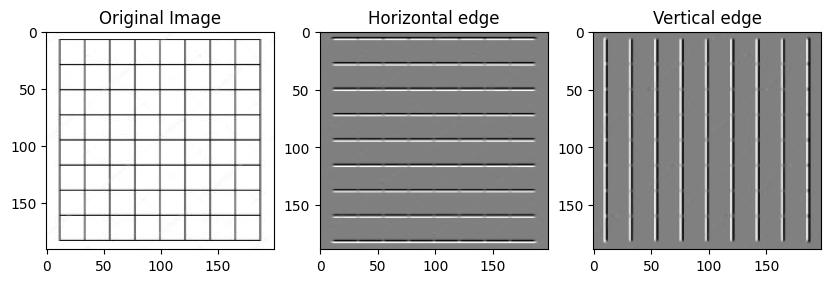

In [8]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,3,1)
ax.imshow(image, cmap='gray')
ax.set_title('Original Image')
ax = fig.add_subplot(1,3,2)
ax.set_title('Horizontal edge')
ax.imshow(out1, cmap='gray')
ax = fig.add_subplot(1,3,3)
ax.imshow(out2, cmap='gray')
ax.set_title('Vertical edge')
plt.show()


## Pooling Layers

Pooling layers are used to reduce the dimensions of the feature maps. Thus, it reduces the number of parameters to learn and the amount of computation performed in the network. The pooling layer summarises the features present in a region of the feature map generated by a convolution layer.

1) Max Pooling:

<img src='https://media.geeksforgeeks.org/wp-content/uploads/20190721025744/Screenshot-2019-07-21-at-2.57.13-AM.png' height=150px/>

2) Average Pooling:

<img src='https://media.geeksforgeeks.org/wp-content/uploads/20190721030705/Screenshot-2019-07-21-at-3.05.56-AM.png' height=150px/>

## Softmax layer/activation
Recall that logistic regression produces a decimal between 0 and 1.0. For example, a logistic regression output of 0.8 from an email classifier suggests an 80% chance of an email being spam and a 20% chance of it being not spam. Clearly, the sum of the probabilities of an email being either spam or not spam is 1.0.

Softmax extends this idea into a multi-class world. That is, Softmax assigns decimal probabilities to each class in a multi-class problem. Those decimal probabilities must add up to 1.0. This additional constraint helps training converge more quickly than it otherwise would.
Softmax is implemented through a neural network layer just before the output layer. The Softmax layer must have the same number of nodes as the output layer.

<img src='https://miro.medium.com/max/1400/1*ReYpdIZ3ZSAPb2W8cJpkBg.jpeg' height=170px />

## Learning to train a CNN network

In [9]:
# Import packages
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [10]:
#  Images returned from torchvision dataset classes is in range [0,1]
# We transform them to tensors and normalize them to range [-1,1] using 'Normalize' transform

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# Classes in CIFAR10
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:03<00:00, 47690695.64it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [11]:
print('Training data shape : ', trainset.data.shape, len(trainset.targets))
print('Testing data shape : ', testset.data.shape, len(testset.targets))

# Find the unique numbers from the train labels
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Training data shape :  (50000, 32, 32, 3) 50000
Testing data shape :  (10000, 32, 32, 3) 10000
Total number of outputs :  10
Output classes :  ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [12]:
def train(num_epochs, model, train_loader, loss_func, optimizer):

  # Training mode
  model.train()

  train_losses = []
  train_acc = []

  # Train the model
  for epoch in range(num_epochs):
    running_loss = 0
    running_acc = 0
    for i, (images, labels) in enumerate(train_loader):

      # clear gradients for this training step
      optimizer.zero_grad()

      # Forward pass
      output = model(images)

      # Calculate loss
      loss = loss_func(output, labels)

      # Backpropagation, compute gradients
      loss.backward()

      # Apply gradients
      optimizer.step()

      # Running loss
      running_loss += loss.item()

      # indices of max probabilities
      _, preds = torch.max(output, dim=1)

      # Calculate number of correct predictions
      correct = (preds.float() == labels).sum()
      running_acc += correct

      # Average loss and acc values
      epoch_loss = running_loss / len(train_loader.dataset)
      epoch_acc = running_acc / len(train_loader.dataset)

    train_losses.append(epoch_loss)
    train_acc.append(epoch_acc)
    print ('Epoch {}/{}, Loss: {:.4f}, Accuracy: {:.4f}'.format(epoch + 1, num_epochs, epoch_loss, epoch_acc*100))

  return train_losses, train_acc

In [13]:
def test_model(model, testloader):
  correct = 0
  total = 0
  # Deactivate autograd engine (don't compute grads since we're not training)
  with torch.no_grad():
    for data in testloader:
        images, labels = data
        # Calculate outputs by running images through the network
        outputs = model(images)
        # The class with the highest value is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

  print('Accuracy of the network: %d %%' % (
      100 * correct / total))

In [14]:
# CNN with 2 CONV layers and 3 FC layers
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32 * 5 * 5, 512)
        self.fc2 = nn.Linear(512, 128)
        # output layer 10 classes
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # flatten all dimensions except batch
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [15]:
model = Net()
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [16]:
# Cross Entropy loss for multi-class classification
criterion = nn.CrossEntropyLoss()

In [17]:
# SGD optimizer with momentum
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)

In [18]:
num_epochs = 5  # iterations
train_losses, train_acc = train(num_epochs, model, trainloader, criterion, optimizer)

Epoch 1/5, Loss: 0.0130, Accuracy: 39.4600
Epoch 2/5, Loss: 0.0094, Accuracy: 57.2920
Epoch 3/5, Loss: 0.0079, Accuracy: 64.5060
Epoch 4/5, Loss: 0.0068, Accuracy: 69.5800
Epoch 5/5, Loss: 0.0058, Accuracy: 73.8960


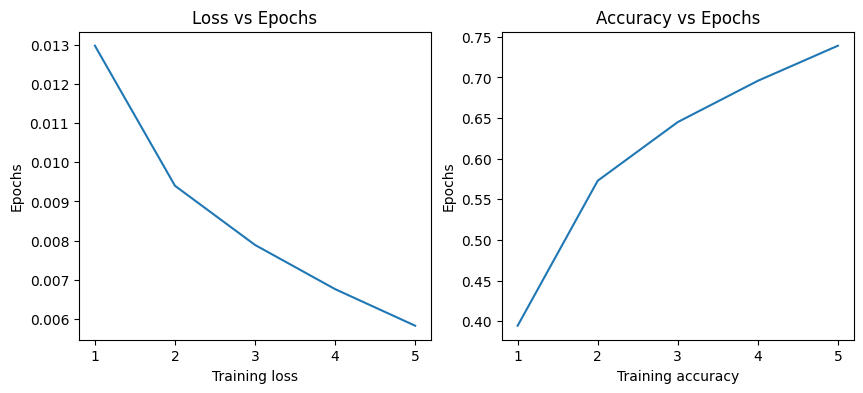

In [19]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2, 1)
ax.plot(np.arange(1,len(train_losses)+1),train_losses)
plt.xlabel('Training loss')
plt.ylabel('Epochs')
ax.set_title('Loss vs Epochs')
ax = fig.add_subplot(1,2, 2)
ax.plot(np.arange(1,len(train_acc)+1),train_acc)
plt.xlabel('Training accuracy')
plt.ylabel('Epochs')
ax.set_title('Accuracy vs Epochs')
plt.show()

In [20]:
# Accuracy on test data after training
test_model(model, testloader)

Accuracy of the network: 66 %


## Questions
1) List some reasons why we should prefer CNN over ANN for image classification?

2) Try improving the CNN performance further by tuning the hyperparameters(epochs, optimizer, LR etc). Report the improved test accuracy.

3) What happens if you reduce the number of convolution layers to only 1?

4) Why didn't we use the Softmax activation in the last layer of CNN?


In [ ]:
#1. CNNs capture local patterns in images, while ANNs treat images as flat vectors so CNNs have spatial awareness but ANNs don't.


In [21]:
#2.
num_epochs = 7  # iterations
train_losses, train_acc = train(num_epochs, model, trainloader, criterion, optimizer)


Epoch 1/7, Loss: 0.0050, Accuracy: 77.6580
Epoch 2/7, Loss: 0.0043, Accuracy: 80.7400
Epoch 3/7, Loss: 0.0037, Accuracy: 83.4160
Epoch 4/7, Loss: 0.0033, Accuracy: 85.3620
Epoch 5/7, Loss: 0.0029, Accuracy: 86.8020
Epoch 6/7, Loss: 0.0027, Accuracy: 88.2780
Epoch 7/7, Loss: 0.0025, Accuracy: 89.2400


In [22]:
# Accuracy on test data after training
test_model(model, testloader)

Accuracy of the network: 65 %


In [23]:
# SGD optimizer with momentum
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

num_epochs = 10  # iterations
train_losses, train_acc = train(num_epochs, model, trainloader, criterion, optimizer)


Epoch 1/10, Loss: 0.0013, Accuracy: 94.6580
Epoch 2/10, Loss: 0.0008, Accuracy: 96.6300
Epoch 3/10, Loss: 0.0007, Accuracy: 97.5080
Epoch 4/10, Loss: 0.0005, Accuracy: 98.0520
Epoch 5/10, Loss: 0.0005, Accuracy: 98.4080
Epoch 6/10, Loss: 0.0004, Accuracy: 98.7120
Epoch 7/10, Loss: 0.0004, Accuracy: 98.9460
Epoch 8/10, Loss: 0.0003, Accuracy: 99.1000
Epoch 9/10, Loss: 0.0003, Accuracy: 99.2380
Epoch 10/10, Loss: 0.0003, Accuracy: 99.3340


In [24]:
# Accuracy on test data after training
test_model(model, testloader)

Accuracy of the network: 69 %


In [ ]:
#3.
#Reducing the number of convolutional layers to only 1 in a CNN limits the model's ability to learn complex features and patterns in images.
#Multiple convolutional layers allow the network to capture intricate details and variations, leading to higher accuracy. With just one layer, the model may struggle to extract meaningful features and may not generalize well to complex image classification tasks.

In [ ]:
#4.bcoz the CrossEntropyLoss function already incorporates the softmax operation internally. CrossEntropyLoss combines the softmax activation with the loss calculation, simplifying the architecture and computation of the model.

## Using learnt representations

<img src="https://miro.medium.com/max/1200/1*QoqNAg2t6lF8Q6WWA6AbOg.png" width=650px/>


In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.


We'll train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.




In [25]:
# Import packages
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import time
import os

In [26]:
# Device configuration (whether to run on GPU or CPU)
device = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [27]:
# Download and extract dataset
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip -q hymenoptera_data.zip

--2023-07-06 13:06:36--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 99.86.38.37, 99.86.38.96, 99.86.38.106, ...
Connecting to download.pytorch.org (download.pytorch.org)|99.86.38.37|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  77.2MB/s    in 0.6s    

2023-07-06 13:06:36 (77.2 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [28]:
# Data augmentation and normalization for training
# Just normalization for validation
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_dir = './hymenoptera_data'
train_dataset = ImageFolder(os.path.join(data_dir, 'train'), train_transform)
val_dataset = ImageFolder(os.path.join(data_dir, 'val'), val_transform)
train_dataloader = DataLoader(train_dataset, batch_size=4,shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=4,shuffle=True, num_workers=2)
class_names = train_dataset.classes


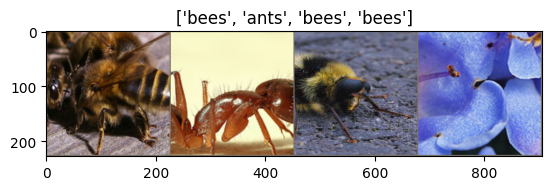

In [29]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [30]:
def train_model(model, train_dataloader, criterion, optimizer, num_epochs=25):

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)

              # backward + optimize only if in training phase
              loss.backward()
              optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataloader.dataset)
        epoch_acc = running_corrects.double() / len(train_dataloader.dataset)

        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

In [31]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [32]:
from torchvision import models

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

loss_func = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 176MB/s]


In [33]:
num_epochs = 5
train_model(model_ft, train_dataloader, loss_func, optimizer, num_epochs)

Epoch 0/4
----------
Loss: 0.5605 Acc: 0.7377

Epoch 1/4
----------
Loss: 0.5761 Acc: 0.7500

Epoch 2/4
----------
Loss: 0.5713 Acc: 0.8197

Epoch 3/4
----------
Loss: 0.5533 Acc: 0.8197

Epoch 4/4
----------
Loss: 0.4345 Acc: 0.8074



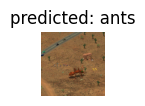

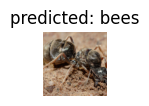

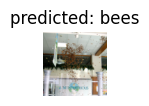

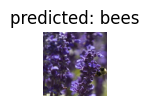

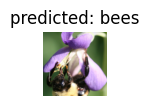

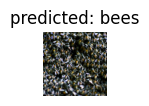

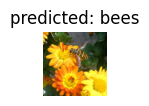

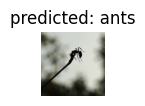

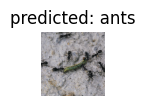

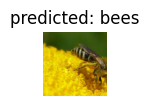

In [34]:
visualize_model(model_ft)

## Example of How Pretrained models are used for Target Tasks

<img src="https://www.researchgate.net/publication/340225334/figure/fig2/AS:960014822944773@1605896778155/Mechanism-of-transfer-learning-using-pre-trained-models.png" width=950px/>

## Questions:
1) What is the significance of using data augmentations like resize, crop etc on training data?

2) What performance do you get if you don't use pretrained resnet model (Hint: Change pretrained=False and train the model)

3) If the resnet model was pre-trained on dataset significantly different than the ants vs bees data, would you still get good performance by using this pretrained model?


In [ ]:
#1 significance of  data augmentations  techniques
# Increase the dataset size by generating additional training examples.
# Improve model robustness by introducing variations and making the model invariant to changes in lighting, viewpoints, etc.
# Act as regularization by adding noise and preventing overfitting.
# Enhance feature representation by focusing on informative parts of the data.

In [37]:
#2
# from torchvision import models

model_ft = models.resnet18(pretrained=False)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

loss_func = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

In [38]:
num_epochs = 5
train_model(model_ft, train_dataloader, loss_func, optimizer, num_epochs)

Epoch 0/4
----------
Loss: 0.7857 Acc: 0.5164

Epoch 1/4
----------
Loss: 0.8493 Acc: 0.5492

Epoch 2/4
----------
Loss: 0.9160 Acc: 0.5082

Epoch 3/4
----------
Loss: 0.7898 Acc: 0.5738

Epoch 4/4
----------
Loss: 0.7535 Acc: 0.5738



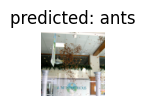

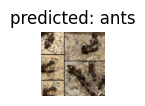

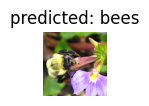

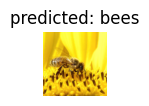

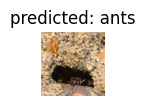

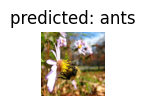

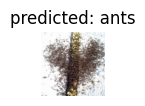

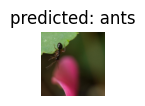

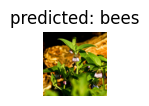

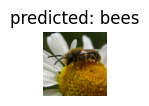

In [39]:
visualize_model(model_ft)

In [ ]:
#3. The level of performance depends on the similarity between the pre-training dataset and the target dataset. If the datasets are similar or share visual characteristics, the pre-trained model can be a valuable starting point and can be fine-tuned for improved performance.
#Even if the datasets are dissimilar, the pre-trained model can still provide useful low-level features that can be adapted to the new task by fine-tuning.
#when the target dataset is small or labeled data is limited, fine-tuning the model on the target dataset and adapting its representations can lead to improved performance.